In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
# read dataframe from GitHup
url = "https://github.com/MIT-Emerging-Talent/ET6-CDSP-group-08-repo/raw/refs/heads/main/1_datasets/cleaned_data/UN_comtrade_clean_dataset.xlsx"
df = pd.read_excel(url, engine="openpyxl")
df.head()

,Year,Country_Code,Country,Product_Code,Product_Description,Net_Weight_kg,Value_USD,Conflict_Year
0,2019,AFG,Afghanistan,854140,"Electrical apparatus; photosensitive, includin...",7.700172e+07,89932863.97,True
1,2007,CAF,Central African Rep.,854140,"Electrical apparatus; photosensitive, includin...",1.796000e+03,26489.00,False
2,2008,CAF,Central African Rep.,854140,"Electrical apparatus; photosensitive, includin...",1.654000e+03,61941.00,False
3,2009,CAF,Central African Rep.,854140,"Electrical apparatus; photosensitive, includin...",7.822000e+03,269897.00,False
4,2010,CAF,Central African Rep.,854140,"Electrical apparatus; photosensitive, includin...",1.234600e+04,173026.00,False


In [3]:
# Define GDP groups based on the provided information

# GDP groups dictionary
gdp_groups = {
    "High GDP": ["Germany", "Saudi Arabia"],
    "Medium GDP": ["Iraq", "Libya", "Morocco", "Nigeria", "Pakistan", "Ukraine"],
    "Low GDP": [
        "Afghanistan",
        "Central African Rep.",
        "Ethiopia",
        "Mali",
        "Mozambique",
        "Myanmar",
        "Rwanda",
        "State of Palestine",
        "Sudan",
        "Sudan (...2011)",
        "Syria",
        "Yemen",
    ],
}


# Create mapping from country to GDP status
def map_gdp_status(country):
    for gdp_status, countries in gdp_groups.items():
        if country in countries:
            return gdp_status
    return "Unknown"


# Apply the mapping to create a new column in the DataFrame
df["GDP_Status"] = df["Country"].apply(map_gdp_status)

df.head(3)

,Year,Country_Code,Country,Product_Code,Product_Description,Net_Weight_kg,Value_USD,Conflict_Year,GDP_Status
0,2019,AFG,Afghanistan,854140,"Electrical apparatus; photosensitive, includin...",7.700172e+07,89932863.97,True,Low GDP
1,2007,CAF,Central African Rep.,854140,"Electrical apparatus; photosensitive, includin...",1.796000e+03,26489.00,False,Low GDP
2,2008,CAF,Central African Rep.,854140,"Electrical apparatus; photosensitive, includin...",1.654000e+03,61941.00,False,Low GDP


In [5]:
# fileter confllict year by country
conflict_years_by_country = df.groupby("Country")["Conflict_Year"].apply(
    lambda x: list(np.unique(x))
)
conflict_years_by_country

Country
Afghanistan                    [True]
Central African Rep.    [False, True]
Ethiopia                [False, True]
Germany                       [False]
Iraq                           [True]
Libya                   [False, True]
Mali                    [False, True]
Morocco                       [False]
Mozambique              [False, True]
Myanmar                 [False, True]
Nigeria                 [False, True]
Pakistan                [False, True]
Rwanda                        [False]
Saudi Arabia                  [False]
State of Palestine             [True]
Sudan                   [False, True]
Sudan (...2011)         [False, True]
Syria                         [False]
Ukraine                 [False, True]
Yemen                   [False, True]
Name: Conflict_Year, dtype: object

In [16]:
# Create a new column 'Conflict_Group' based on whether a country has continuous, periodical, or no conflict years.
def get_conflict_group(row):
    country = row["Country"]
    has_true = True in conflict_years_by_country.get(country, [])
    has_false = False in conflict_years_by_country.get(country, [])

    if has_true and has_false:
        return "Periodical Conflict"
    elif has_true and not has_false:
        return "Continuous Conflict"
    else:
        return "Non-conflict"


df["Conflict_Group"] = df.apply(get_conflict_group, axis=1)
df.sample(5)

,Year,Country_Code,Country,Product_Code,Product_Description,Net_Weight_kg,Value_USD,Conflict_Year,GDP_Status,Conflict_Group,Product_Category
1019,2006,MAR,Morocco,850440,Electrical static converters,1.855794e+06,2.170270e+07,False,Medium GDP,Non-conflict,Inverters
1146,2015,DEU,Germany,854140,"Electrical apparatus; photosensitive, includin...",1.297097e+08,2.762102e+09,False,High GDP,Non-conflict,PV Modules
1233,2021,RWA,Rwanda,854140,"Electrical apparatus; photosensitive, includin...",8.361322e+05,6.435554e+06,False,Low GDP,Non-conflict,PV Modules
1067,2010,MAR,Morocco,851310,"Lamps; portable, electric, designed to functio...",7.461930e+05,2.628837e+06,False,Medium GDP,Non-conflict,Solar Lamps
650,2022,MOZ,Mozambique,851310,"Lamps; portable, electric, designed to functio...",4.792090e+05,1.815625e+06,False,Low GDP,Periodical Conflict,Solar Lamps


In [17]:
# Product Categorization ---
def categorize_product(description):
    description = str(description).lower()
    if "photovoltaic" in description:
        return "PV Modules"
    elif "static converter" in description:
        return "Inverters"
    elif "lead-acid" in description:
        return "Lead-Acid Batteries"
    elif "lithium-ion" in description:
        return "Lithium Batteries"
    elif "portable" in description and "electric" in description:
        return "Solar Lamps"
    elif "electric generator" in description:
        return "Solar Generators"
    else:
        return "Other"


df["Product_Category"] = df["Product_Description"].apply(categorize_product)

C:\Users\زينب\AppData\Local\Temp\ipykernel_72372\2169584068.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Conflict_Group', y='Value_USD', hue='GDP_Status',


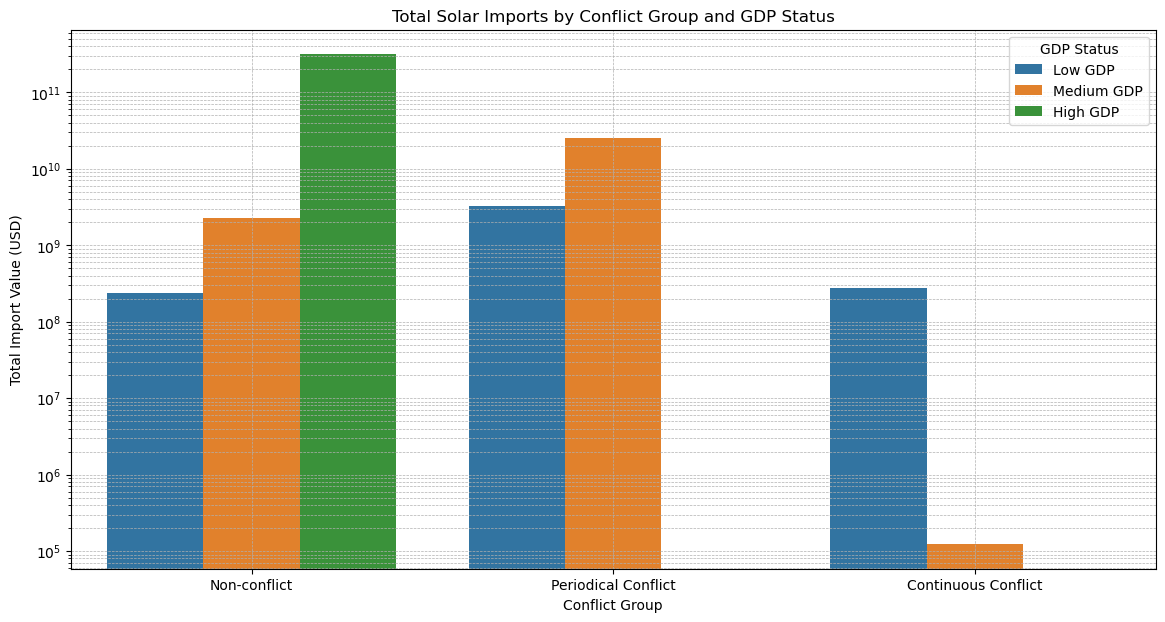

In [18]:
# Analysis 1: Solar Adoption by Conflict Group and GDP Status ---
plt.figure(figsize=(14, 7))
sns.barplot(
    data=df,
    x="Conflict_Group",
    y="Value_USD",
    hue="GDP_Status",
    estimator=sum,
    ci=None,
    order=["Non-conflict", "Periodical Conflict", "Continuous Conflict"],
)
plt.title("Total Solar Imports by Conflict Group and GDP Status")
plt.ylabel("Total Import Value (USD)")
plt.xlabel("Conflict Group")
plt.yscale("log")  # Use log scale for better visualization of large differences
plt.legend(title="GDP Status")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

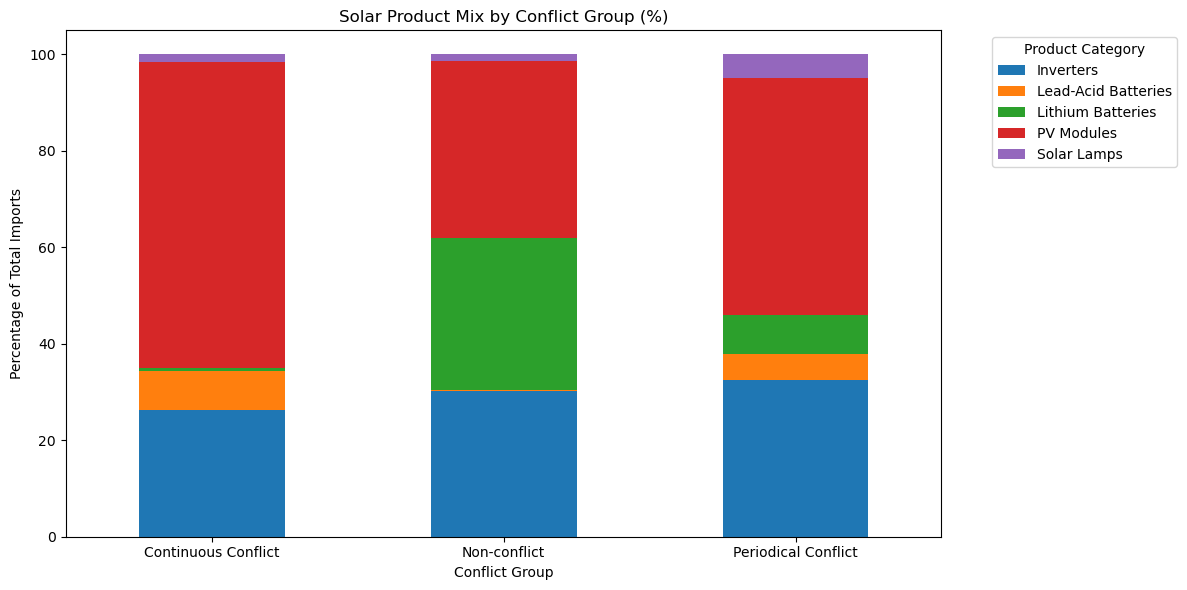

In [19]:
# Analysis 2: Product Mix Across Conflict Groups ---
product_mix = (
    df.groupby(["Conflict_Group", "Product_Category"])["Value_USD"].sum().unstack()
)

# Normalize to show percentages
product_mix_percent = product_mix.div(product_mix.sum(axis=1), axis=0) * 100

product_mix_percent.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("Solar Product Mix by Conflict Group (%)")
plt.ylabel("Percentage of Total Imports")
plt.xlabel("Conflict Group")
plt.xticks(rotation=0)
plt.legend(title="Product Category", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

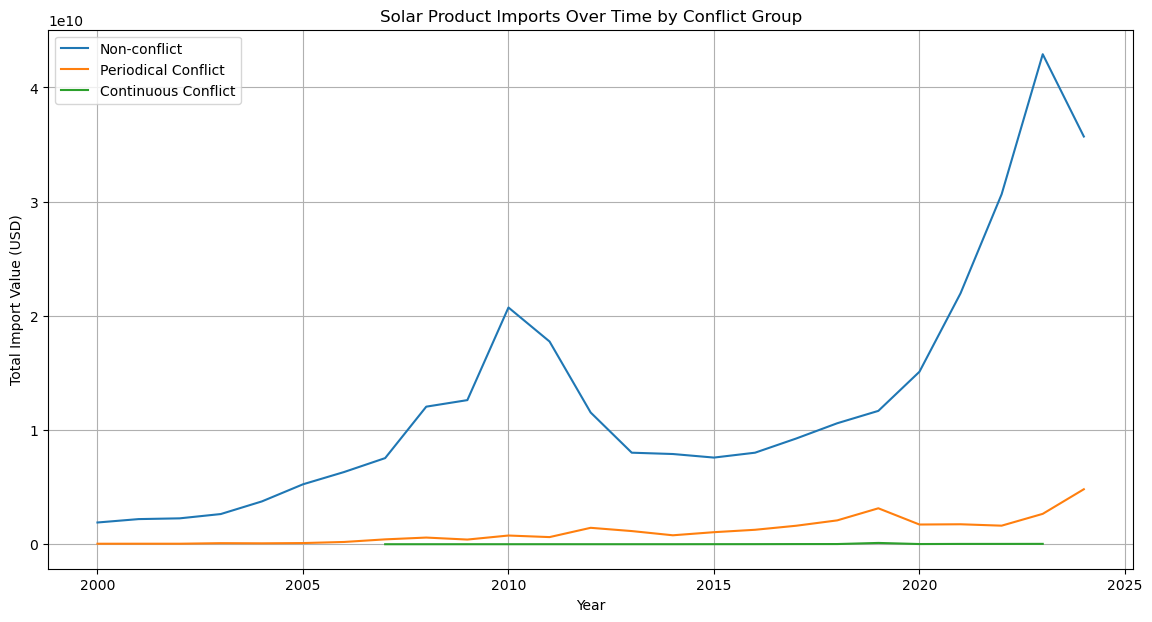

In [11]:
# Analysis 3: Time Trends by Conflict Group ---
plt.figure(figsize=(14, 7))
for group in ["Non-conflict", "Periodical Conflict", "Continuous Conflict"]:
    group_data = df[df["Conflict_Group"] == group]
    trend = group_data.groupby("Year")["Value_USD"].sum()
    plt.plot(trend.index, trend, label=group)

plt.title("Solar Product Imports Over Time by Conflict Group")
plt.ylabel("Total Import Value (USD)")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
plt.show()

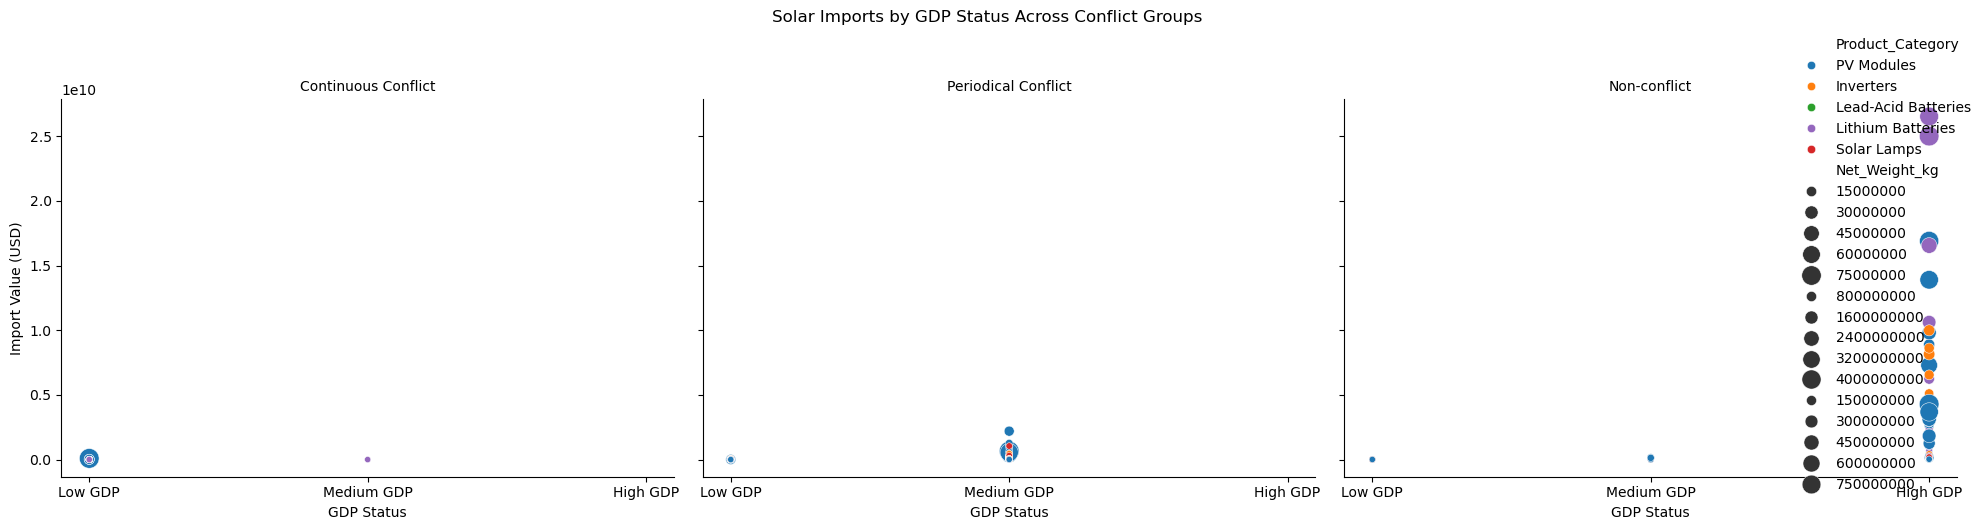

In [20]:
# Analysis 4: GDP vs Solar Adoption Faceted by Conflict Group ---
g = sns.FacetGrid(df, col="Conflict_Group", height=5, aspect=1.2)
g.map_dataframe(
    sns.scatterplot,
    x="GDP_Status",
    y="Value_USD",
    hue="Product_Category",
    size="Net_Weight_kg",
    sizes=(20, 200),
)
g.set_axis_labels("GDP Status", "Import Value (USD)")
g.set_titles("{col_name}")
g.add_legend()
plt.suptitle("Solar Imports by GDP Status Across Conflict Groups", y=1.05)
plt.tight_layout()
plt.show()

In [14]:
# Analysis 5: Statistical Summary ---
conflict_stats = df.groupby(["Conflict_Group", "GDP_Status"]).agg(
    {"Value_USD": ["mean", "median", "sum"], "Net_Weight_kg": "mean"}
)

print("\nStatistical Comparison by Conflict Group and GDP Status:")
print(conflict_stats)


Statistical Comparison by Conflict Group and GDP Status:
                                   Value_USD                              \
                                        mean        median           sum   
Conflict_Group      GDP_Status                                             
Continuous Conflict Low GDP     3.789774e+06  4.492096e+05  2.728637e+08   
                    Medium GDP  1.227320e+05  1.227320e+05  1.227320e+05   
Non-conflict        High GDP    1.632752e+09  1.285895e+08  3.134884e+11   
                    Low GDP     2.313255e+06  8.807169e+05  2.359520e+08   
                    Medium GDP  2.523981e+07  6.570057e+06  2.246343e+09   
Periodical Conflict Low GDP     6.213413e+06  1.736558e+06  3.243402e+09   
                    Medium GDP  7.712351e+07  1.934919e+07  2.529651e+10   

                               Net_Weight_kg  
                                        mean  
Conflict_Group      GDP_Status                
Continuous Conflict Low GDP     2.163538

C:\Users\زينب\AppData\Local\Temp\ipykernel_72372\120927690.py:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  resampled = group_data.resample("Y", on="Year_dt")["Value_USD"].sum()


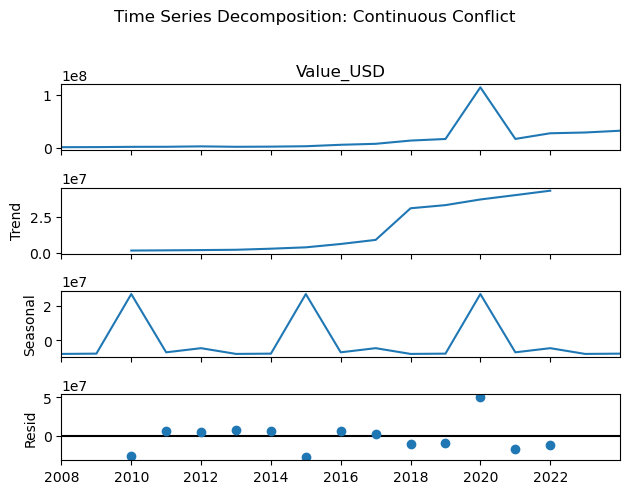

C:\Users\زينب\AppData\Local\Temp\ipykernel_72372\120927690.py:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  resampled = group_data.resample("Y", on="Year_dt")["Value_USD"].sum()


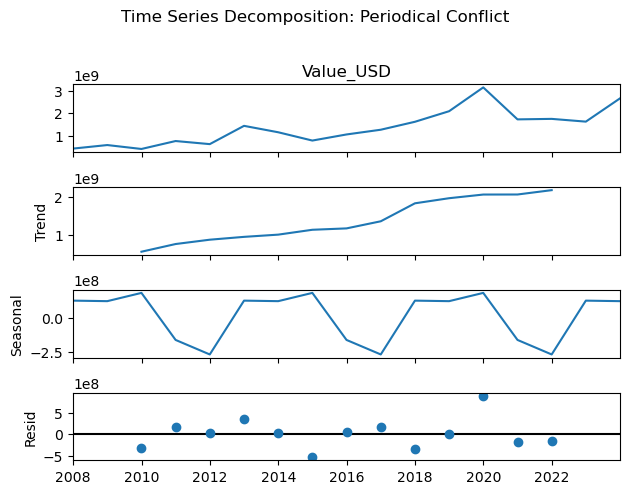

C:\Users\زينب\AppData\Local\Temp\ipykernel_72372\120927690.py:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  resampled = group_data.resample("Y", on="Year_dt")["Value_USD"].sum()


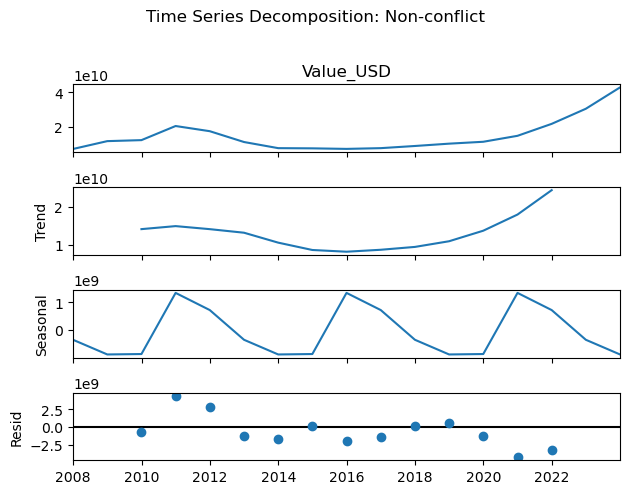

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Filter for relevant time period
df_time = df[df["Year"].between(2007, 2023)]

# Decompose trends for each conflict group
for group in df["Conflict_Group"].unique():
    group_data = df_time[df_time["Conflict_Group"] == group].copy()
    # Convert 'Year' to datetime (set to Jan 1st of each year)
    group_data["Year_dt"] = pd.to_datetime(group_data["Year"], format="%Y")
    resampled = group_data.resample("Y", on="Year_dt")["Value_USD"].sum()
    decomposition = seasonal_decompose(resampled, model="additive", period=5)

    fig = decomposition.plot()
    fig.suptitle(f"Time Series Decomposition: {group}", y=1.02)
    plt.tight_layout()
    plt.show()

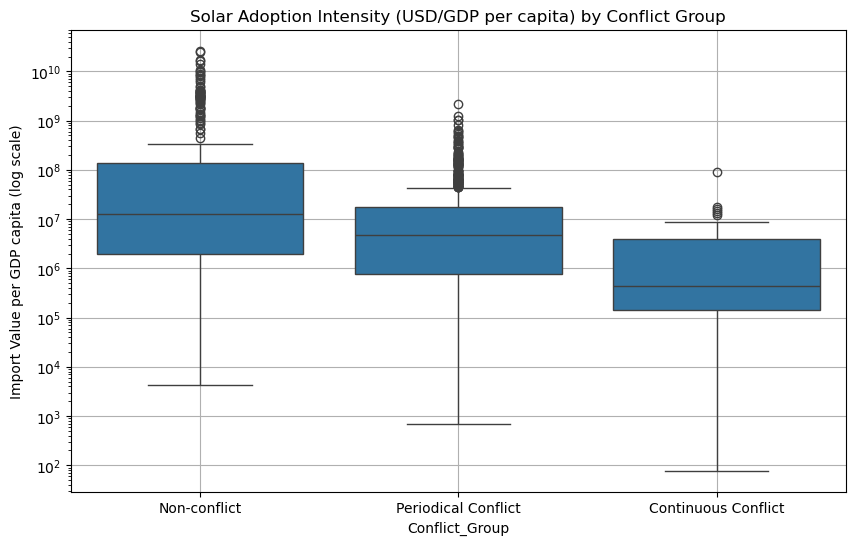

In [25]:
# Ensure 'GDP_per_capita' exists, otherwise set to a default value (e.g., 1 to avoid division by zero)
if "GDP_per_capita" not in df.columns:
    # If you have GDP and population columns, uncomment and use the following:
    # df["GDP_per_capita"] = df["GDP"] / df["Population"]
    # Otherwise, set to a default value to avoid error
    df["GDP_per_capita"] = 1  # Replace with actual calculation if data is available

# Create conflict intensity metric (Value_USD per GDP capita)
df["Conflict_Intensity"] = df.apply(
    lambda x: x["Value_USD"] / x["GDP_per_capita"] if x["GDP_per_capita"] > 0 else 0,
    axis=1,
)

# Plot intensity by conflict group
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x="Conflict_Group",
    y="Conflict_Intensity",
    order=["Non-conflict", "Periodical Conflict", "Continuous Conflict"],
)
plt.title("Solar Adoption Intensity (USD/GDP per capita) by Conflict Group")
plt.yscale("log")
plt.ylabel("Import Value per GDP capita (log scale)")
plt.grid(True)

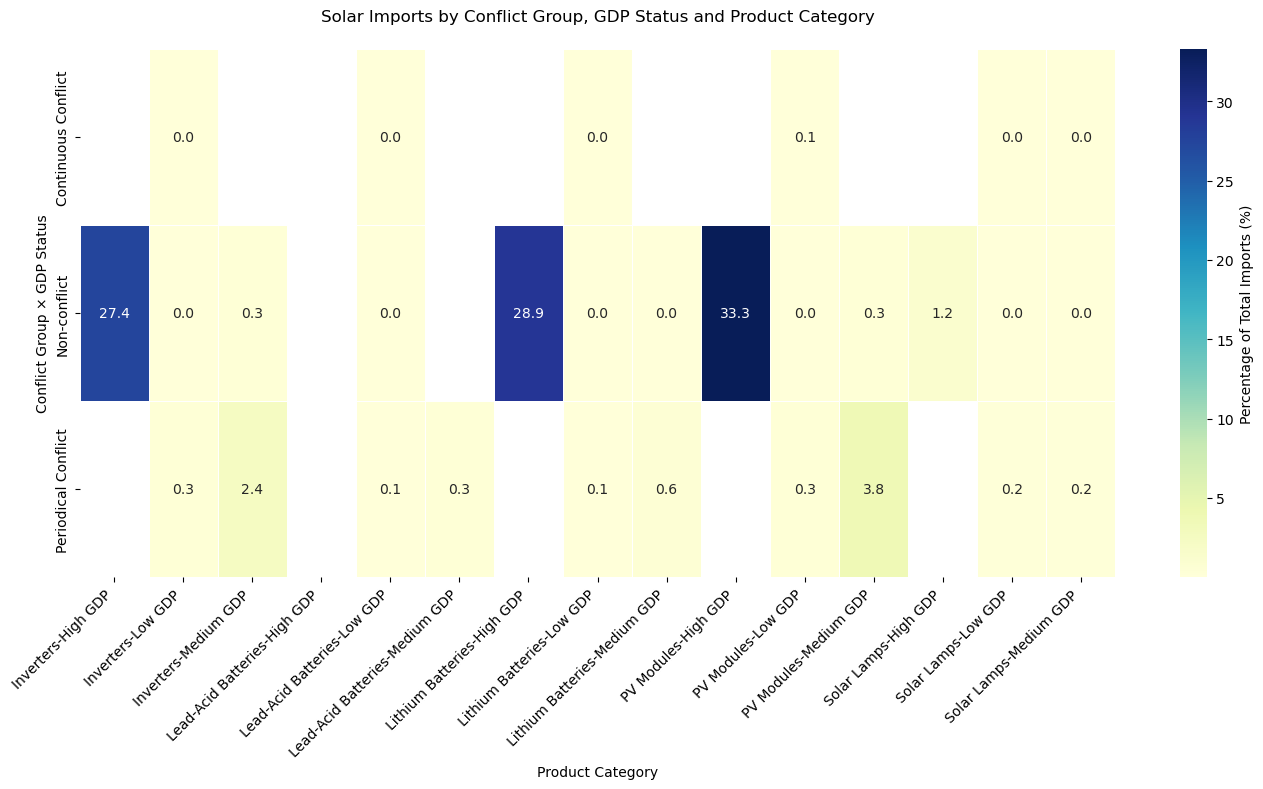

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the data for heatmap
heatmap_data = (
    df.groupby(["Conflict_Group", "GDP_Status", "Product_Category"])["Value_USD"]
    .sum()
    .unstack()
    .unstack()
)

# Normalize the data to show percentage of total imports
heatmap_data_percent = heatmap_data.div(heatmap_data.sum().sum()) * 100

# Create the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data_percent,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={"label": "Percentage of Total Imports (%)"},
)

# Customize the plot
plt.title("Solar Imports by Conflict Group, GDP Status and Product Category", pad=20)
plt.xlabel("Product Category")
plt.ylabel("Conflict Group × GDP Status")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Show the plot
plt.show()

In [29]:
# Calculate recovery rates post-conflict

# Get countries with at least one conflict year
conflict_countries = [
    country for country, years in conflict_years_by_country.items() if True in years
]

recovery_data = []
for country in conflict_countries:
    # Find the last year of conflict for the country
    conflict_years = df[(df["Country"] == country) & (df["Conflict_Year"] == True)][
        "Year"
    ]
    if len(conflict_years) == 0:
        continue
    conflict_end = conflict_years.max()
    # Data after conflict
    post_conflict = df[(df["Country"] == country) & (df["Year"] > conflict_end)]
    if len(post_conflict) > 0:
        recovery_rate = (
            post_conflict["Value_USD"].mean()
            / df[df["Country"] == country]["Value_USD"].max()
        )
        recovery_data.append({"Country": country, "Recovery_Rate": recovery_rate})
print("Identifies which countries recover fastest after conflicts")
pd.DataFrame(recovery_data).sort_values("Recovery_Rate", ascending=False)

Identifies which countries recover fastest after conflicts


,Country,Recovery_Rate
5,Sudan,0.388494
6,Sudan (...2011),0.342208
1,Mozambique,0.287480
2,Myanmar,0.223218
7,Ukraine,0.169434
4,Pakistan,0.159041
0,Ethiopia,0.153662
3,Nigeria,0.144701
